In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import create_model
import data_manipulator
import time
import data_reader
import finance_calculator


In [2]:
SEQ_LEN = 60 
FUTURE_PERIOD_PREDICT = 1  
ASSET_TO_PREDICT = 'rx1'          # --VAR CHANGE 

In [3]:
# Read in and preprocess data
# CREDIT DATA
credit_df = pd.DataFrame() # begin empty
rx1, ty1, ik1, oe1, du1 = data_reader.credit()
credit_df['rx1'] = rx1['RX1 Comdty']
# credit_df['ty1'] = ty1['TY1 Comdty']
# credit_df['ik1'] = ik1['IK1 Comdty']
# credit_df['oe1'] = oe1['OE1 Comdty']
# credit_df['du1'] = du1['DU1 Comdty']

# CRYPTO DATA
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"] 
crypto_df = data_reader.crypto(ratios)

# set the dataset                           --VAR CHANGE
dataset_df = credit_df 

dataset_df[f't+1'] = dataset_df[f'{ASSET_TO_PREDICT}'].shift(-FUTURE_PERIOD_PREDICT)
dataset_df['target'] = list(map(utils.classify, dataset_df[f'{ASSET_TO_PREDICT}'], dataset_df['t+1']))

train_df, validation_df = data_manipulator.splitter(dataset_df, cutoff=0.10)

train_x, train_y = data_manipulator.preprocess(train_df, SEQ_LEN)
validation_x, validation_y = data_manipulator.preprocess(validation_df, SEQ_LEN)

Ups:  2494
Downs:  2222
Ups:  204
Downs:  266


In [4]:
my_time = time.strftime('%m.%d.%H%M', time.localtime(int(time.time())))
print(my_time)
EPOCHS = 30
BATCH_SIZE = 8
NAME = f'{my_time}-{ASSET_TO_PREDICT}-{SEQ_LEN}-{FUTURE_PERIOD_PREDICT}-lstm-sigmoid'  # a name for the model

01.21.2155


In [5]:
model = create_model.lstm_sigmoid(train_x) #REMEMBER TO CHANGE NAME ABOVE!!!!

In [6]:
checkpoint_filepath = f'models/{NAME}-checkpoint-' + '-{epoch:02d}-{val_accuracy:.3f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

In [7]:
# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=[checkpoint],
)


Epoch 1/30


2023-01-21 21:55:39.667611: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


556/556 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.4865
Epoch 1: val_accuracy improved from -inf to 0.48039, saving model to models/01.21.2155-rx1-60-1-lstm-sigmoid-checkpoint--01-0.480.hdf5
556/556 [==============================] - 68s 112ms/step - loss: 0.8585 - accuracy: 0.4865 - val_loss: 0.7527 - val_accuracy: 0.4804
Epoch 2/30
556/556 [==============================] - ETA: 0s - loss: 0.7920 - accuracy: 0.4995
Epoch 2: val_accuracy did not improve from 0.48039
556/556 [==============================] - 61s 110ms/step - loss: 0.7920 - accuracy: 0.4995 - val_loss: 0.7281 - val_accuracy: 0.4657
Epoch 3/30
556/556 [==============================] - ETA: 0s - loss: 0.7649 - accuracy: 0.5018
Epoch 3: val_accuracy did not improve from 0.48039
556/556 [==============================] - 62s 111ms/step - loss: 0.7649 - accuracy: 0.5018 - val_loss: 0.7220 - val_accuracy: 0.4657
Epoch 4/30
556/556 [==============================] - ETA: 0s - loss: 0.7601 - accur

In [8]:
loss, acc = model.evaluate(validation_x, validation_y, verbose=0)
print("Model, Test loss: {:5.2f}".format(loss))
print("Model, test accuracy: {:5.2f}%".format(100 * acc))

model.save(f"models/{NAME}.hdf5")
if hasattr(history, 'history'):
    np.save(f'history/{NAME}.npy',history.history)
    print("Saved history") #should happen at first run of this block after model.fit ran

Model, Test loss:  0.70
Model, test accuracy: 48.77%
Saved history


In [9]:
# load back history data
model_load = keras.models.load_model(f'models/{NAME}.hdf5')
history_load = np.load(f'history/{NAME}.npy',allow_pickle='TRUE').item()

loss, acc = model_load.evaluate(validation_x, validation_y, verbose=0)
print("Restored model, test loss: {:5.2f}".format(loss))
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))

Restored model, test loss:  0.70
Restored model, test accuracy: 48.77%


In [10]:
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.titlesize"] = 17
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu
#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

32

01.21.2155-rx1-60-1-lstm-sigmoid


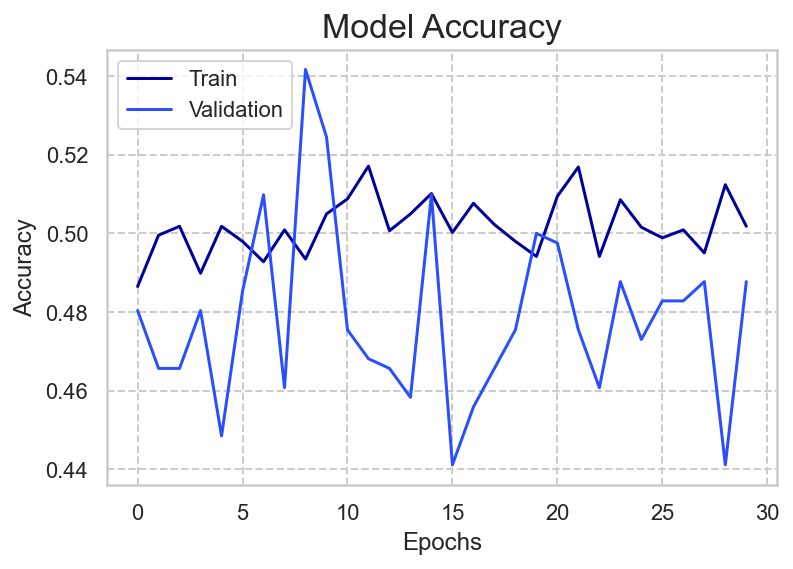

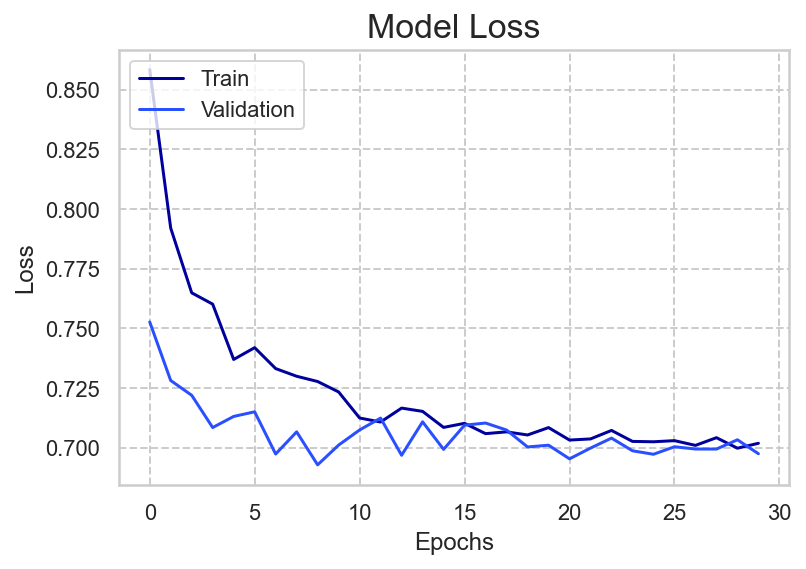

In [11]:
fig1, axs1, fig2, axs2 = utils.plot_history_data(history_load)
with open('models/last_run_model_name.txt', 'w') as f:
    f.write(NAME)
    print(NAME)


In [12]:
history_load['loss']

[0.8584972023963928,
 0.7920237183570862,
 0.764894962310791,
 0.7601441740989685,
 0.7369691729545593,
 0.7419092059135437,
 0.733144223690033,
 0.7299240231513977,
 0.7277197241783142,
 0.723347544670105,
 0.7124314308166504,
 0.7107365727424622,
 0.7165797352790833,
 0.7152085900306702,
 0.7084885239601135,
 0.7101998329162598,
 0.7058736085891724,
 0.7066227793693542,
 0.7053112387657166,
 0.7084086537361145,
 0.703183650970459,
 0.7036586999893188,
 0.7072196006774902,
 0.7026193141937256,
 0.7024644613265991,
 0.7029365301132202,
 0.7009486556053162,
 0.7041823267936707,
 0.6997637152671814,
 0.7018352746963501]